In [1]:
import numpy as np
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
class Flow:
    def __init__(self, K = 0.282):        
        # Diffusion cooficent source: https://en.wikipedia.org/wiki/Mass_diffusivity
        self.K = K
        
        self.dt = 0.5
        self.dx = 1
        self.dy = 1
        
        self.L = 100
        self.B = 100
        self.T = 300
        
        x = np.arange(0, self.L, self.dx)
        y = np.arange(0, self.B, self.dy)
        t = np.arange(0, self.T, self.dt)
        self.x,self.t,self.y = np.meshgrid(x,t, y)
        
        r = ((self.x-self.B/2)**2 + (self.y-self.L/2)**2)**0.5
        r = r/r.max()

        self.u = -r*np.ones((self.x.shape[0], self.x.shape[1],self.x.shape[2])) * np.cos(np.pi * self.y / self.B)
        self.v = r*np.ones((self.x.shape[0], self.x.shape[1],self.x.shape[2])) * np.cos(np.pi * self.x / self.L)
        
        
        # Boundary of c = 0
        self.c = np.zeros((self.x.shape[0], self.x.shape[1],self.x.shape[2]))
        self.c[1:, 1:-1, 1:-1] = np.nan 
        
        # Set initial condition of c
        self.c[
            0, 
            int(0.25 * self.x.shape[1]):int(0.75 *self.x.shape[1]), 
            int(0.48 * self.x.shape[2]):int(0.52 * self.x.shape[2])
        ] = 1
        
        u_bar = (self.u **2 + self.v**2) ** 0.5
        print(f"q = {self.K *self.dt/(self.dx**2)} < 1/2")
        print(f"P_Delta = {u_bar.max() * self.dx / self.K } < 2")
        
   
    def Kdcdx2(self, t, x, y):
        return self.K * (self.c[t-1,x-1,y] - 2 * self.c[t-1,x,y] + self.c[t-1,x+1,y])/(self.dx ** 2)
    
    def Kdcdy2(self, t, x, y):
        return self.K * (self.c[t-1,x,y-1] - 2 * self.c[t-1,x,y] + self.c[t-1,x,y+1])/(self.dy ** 2)
    
    def vdcdx(self, t, x, y):
        return self.u[t-1,x,y] * (self.c[t-1,x+1,y] - self.c[t-1,x-1,y])/ (2 * self.dx)
    
    def udcdy(self, t, x, y):
        return self.v[t-1,x,y] * (self.c[t-1,x,y+1] - self.c[t-1,x,y-1])/ (2 * self.dy)
    
    def run(self):
        for k in range(1, self.c.shape[0]):
            clear_output(True)
            print(f"{np.round(k/self.c.shape[0] * 100, 2)} %")
            
            for i in range(1, self.c.shape[1]-1):
                for j in range(1, self.c.shape[2]-1):      
                    new_c = self.c[k-1,i,j] + self.dt * (
                        self.Kdcdx2(k,i,j)+
                        self.Kdcdy2(k,i,j)-
                        self.udcdy(k,i,j)-
                        self.vdcdx(k,i,j)
                    )
                    self.c[k,i,j] = new_c

# 1. Equations

[Wikipedia](https://en.wikipedia.org/wiki/Convection%E2%80%93diffusion_equation) says: 

The general Convection–diffusion equation is:

\begin{equation*}
{\displaystyle {\frac {\partial c}{\partial t}}=\mathbf {\nabla } \cdot (\kappa \mathbf {\nabla } c)-\mathbf {\nabla } \cdot (\mathbf {v} c)+R}
\end{equation*}

In a common situation, the diffusion coefficient is constant, there are no sources or sinks, and the velocity field describes an incompressible flow (i.e., it has zero divergence). Then the formula simplifies to:

u = flow in x-direction

v = flow in y-direction

\begin{equation*}
\displaystyle {\frac {\partial c}{\partial t}}=\kappa \nabla ^{2}c-\mathbf {v} \cdot \nabla c
\end{equation*}

\begin{equation*}
\displaystyle {\frac {\partial c}{\partial t}}=\kappa \nabla ^{2}c- u \displaystyle {\frac {\partial c}{\partial x}} - v \displaystyle {\frac {\partial c}{\partial y}}
\end{equation*}

\begin{equation*}
\displaystyle {\frac {\partial c}{\partial t}}=\kappa \displaystyle {\frac {\partial  ^{2} c}{\partial x ^{2}}} + \kappa \displaystyle {\frac {\partial  ^{2} c}{\partial y  ^{2}}}- u \displaystyle {\frac {\partial c}{\partial x}} - v \displaystyle {\frac {\partial c}{\partial y}}
\end{equation*}

# 2. Numeric solution

* central differences in space
* Euler foreward in time

Resulting in the following stability conditions:

\begin{equation}
\displaystyle {\frac {\kappa \Delta t}{\Delta x ^ 2}} = q < \displaystyle {\frac {1}{2}}
\end{equation}

\begin{equation*}
|\displaystyle {\frac {u \Delta x}{\kappa}}| = |P_{\Delta}| < 2
\end{equation*}


With the discretisation:


\begin{equation*}
\displaystyle {\frac  {c(x=0,y=0,t=1)-c(x=0,y=0,t=0)}{\Delta t}} = \\
\kappa {\frac  {c(x=-1,y=0,t=0)-2c(x=0,y=0,t=0)+c(x=1,y=0,t=0)}
{\Delta x^{2}}} + \\
\kappa {\frac  {c(x=0,y=-1,t=0)-2c(x=0,y=0,t=0)+c(x=0,y=1,t=0)}
{\Delta x^{2}}} - \\
u{\frac  {c(x=1,y=0,t=0)-c(x=-1,y=0,t=0)}
{2\Delta x}} - \\
v{\frac  {c(x=0,y=1,t=0)-c(x=0,y=-1,t=0)}
{2\Delta x}}
\end{equation*}

# 3. Generate flow field

In [3]:
f = Flow()

q = 0.141 < 1/2
P_Delta = 5.0149417105428915 < 2


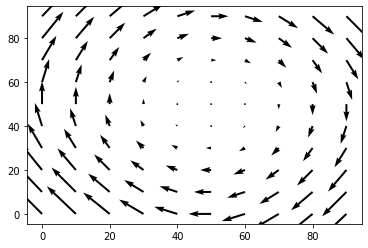

In [4]:
%matplotlib inline
dd =10
t = 0

plt.quiver(
    f.x[t,::dd,::dd],
    f.y[t,::dd,::dd],
    f.u[t,::dd,::dd],
    f.v[t,::dd,::dd]
)

plt.show()

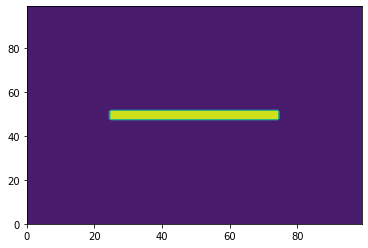

In [5]:
%matplotlib inline

t=0
dd=1
plt.contourf(
    f.x[t,::dd,::dd],
    f.y[t,::dd,::dd],
    f.c[t,::dd,::dd],
)

plt.show()

# 4. Run the computation

In [6]:
%%time
f.run()

99.83 %
Wall time: 40 s


# 5. Plot the results

<IPython.core.display.Javascript object>


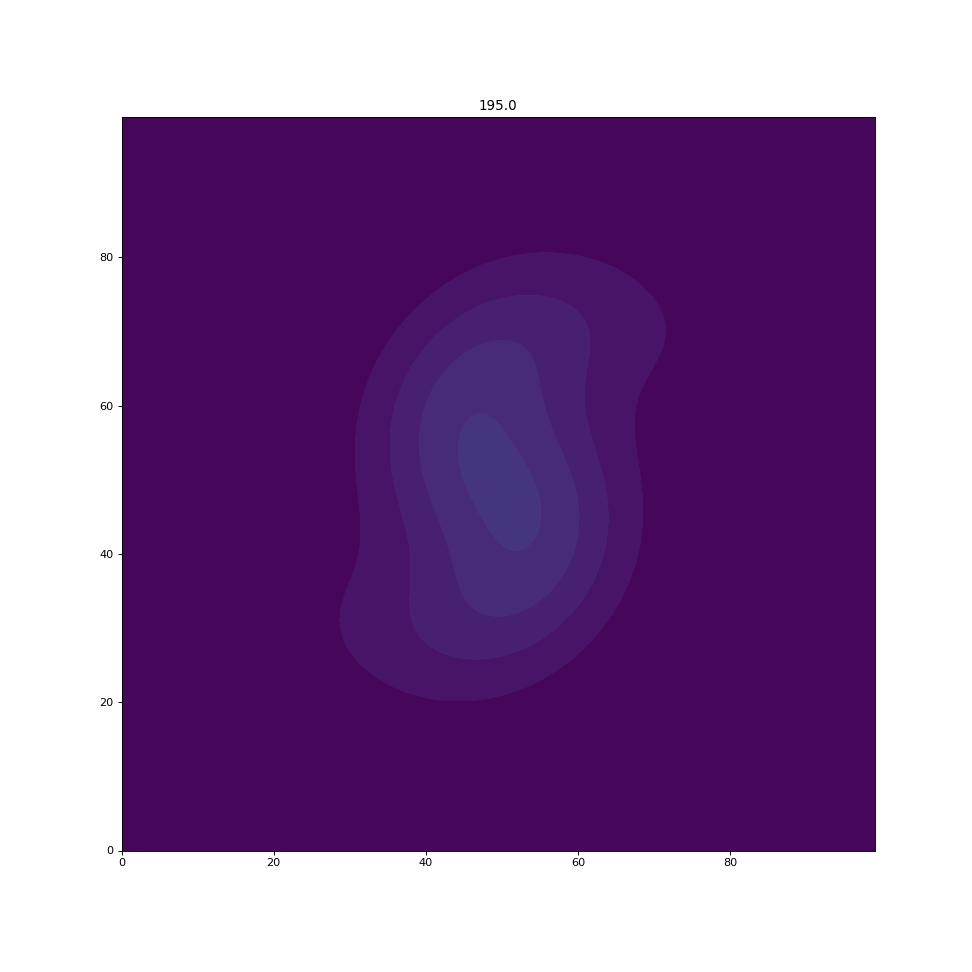

In [9]:
%matplotlib notebook

fig,ax = plt.subplots(figsize = (12,12))
cval = np.linspace(f.c.min(), f.c.max(), 30)
dd =1
DT = 10

def animate(i):
    t = i* DT
    ax.clear()
    ax.set_title(f"{np.round(f.t[t,0,0], 2)}") 
    CS1 = ax.contourf(
        f.x[t,::dd,::dd],
        f.y[t,::dd,::dd],
        f.c[t,::dd,::dd],
        levels=cval
    )


interval = 0.1  #in seconds     
ani = animation.FuncAnimation(
    fig,animate,
    int(f.x.shape[0]/DT),
    interval=interval*1e+3,
    blit=False
)

plt.show()